In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import shap
from google.colab import files

In [416]:

# Upload files from local machine to Colab
uploaded = files.upload()

Saving Test.xlsx to Test (19).xlsx
Saving Train.xlsx to Train (19).xlsx


In [417]:
# Read the uploaded files into pandas DataFrames
training_data = pd.read_excel('/content/Train.xlsx')
testing_data = pd.read_excel('/content/Test.xlsx')

***about the dataset***


Mammography is the most effective method for breast cancer screening available today. However, the low positive predictive value of breast biopsy resulting from mammogram interpretation leads to approximately 70% unnecessary biopsies with benign outcomes. To reduce the high number of unnecessary breast biopsies, several computer-aided diagnoses (CAD) systems have been proposed in the last years. These systems help physicians in their decision to perform a breast biopsy on a suspicious lesion seen in a mammogram or to perform a short-term follow-up examination instead.

This data set can be used to predict the severity (benign or malignant) of a mammographic mass lesion from BI-RADS attributes and the patient's age. It contains a BI-RADS assessment, the patient's age and three BI- RADS attributes together with the ground truth (the severity field).

Attribute Information:
1.	BI-RADS assessment: 1 to 5 (ordinal, non-predictive!)
2.	Age: patient's age in years (integer)
3.	Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
4.	Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
5.	Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
6.	Severity: benign=0 or malignant=1 (binominal, goal field!)


In [418]:
training_data

,Index,BI_RADS,Age,Shape,Margin,Mass_Density,Severity
0,1,5.0,67.0,lobular,spiculated,low,1
1,2,4.0,43.0,round,circumscribed,NaN,1
2,3,5.0,58.0,irregular,spiculated,low,1
3,4,4.0,28.0,round,circumscribed,low,0
4,5,5.0,74.0,round,spiculated,NaN,1
...,...,...,...,...,...,...,...
806,807,5.0,62.0,irregular,ill-defined,iso,1
807,808,4.0,56.0,oval,circumscribed,low,0
808,809,5.0,58.0,irregular,ill-defined,low,1
809,810,4.0,NaN,round,ill-defined,low,0


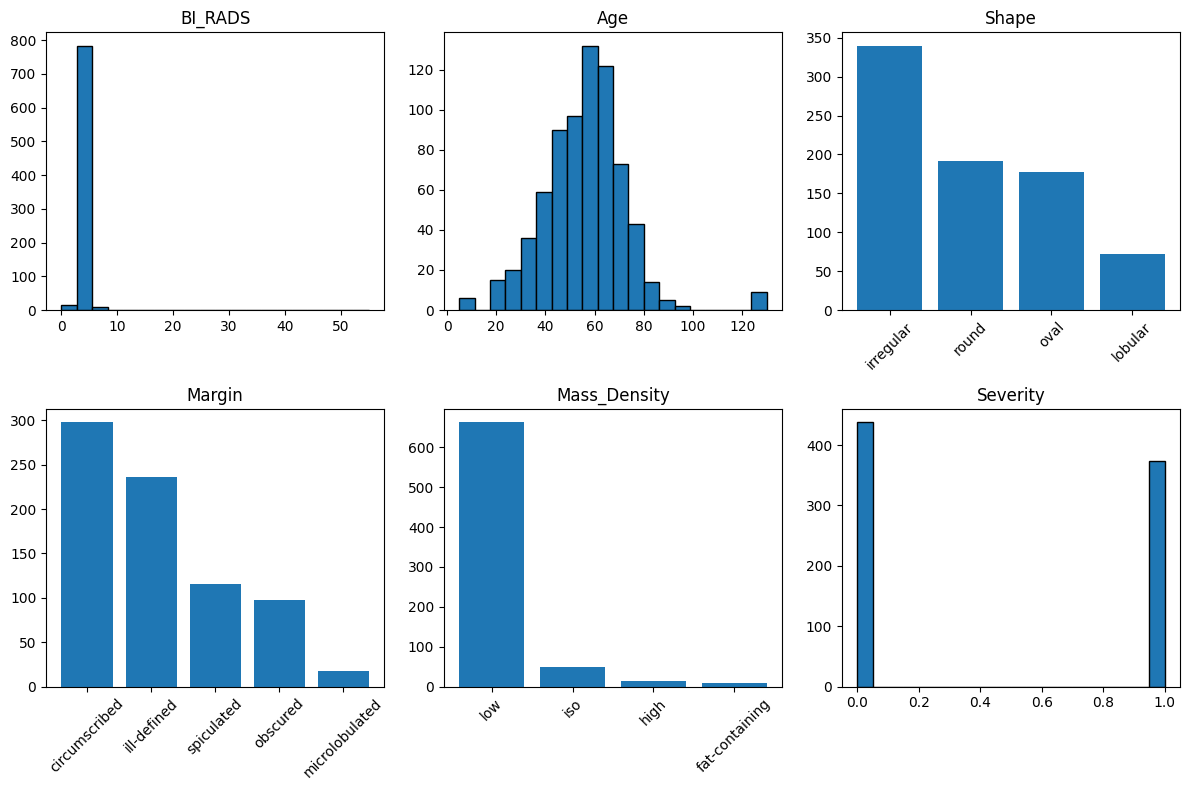

In [419]:

# data distribution

columns_for_distribution = ['BI_RADS', 'Age', 'Shape', 'Margin', 'Mass_Density', 'Severity']

# Create histograms for numeric features and bar plots for categorical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(columns_for_distribution):
    plt.subplot(2, 3, i+1)

    # Check if the feature is numeric or categorical
    if training_data[col].dtype in [int, float]:
        plt.hist(training_data[col], bins=20, edgecolor='black')
    else:
        value_counts = training_data[col].value_counts()
        plt.bar(value_counts.index, value_counts.values)
        plt.xticks(rotation=45)

    plt.title(col)
plt.tight_layout()
plt.show()

In [420]:
# box plot


8.0
6.0


<Axes: ylabel='Severity'>

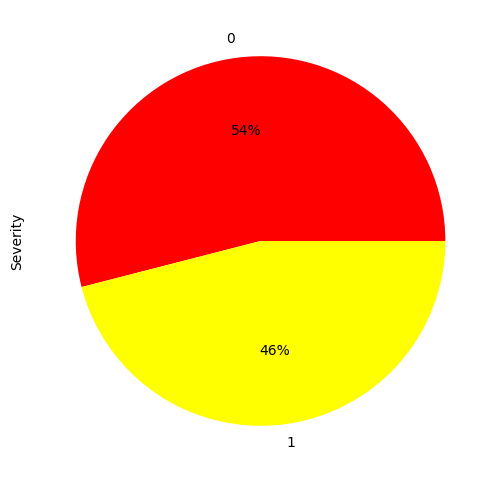

In [421]:
#plotting the target varible
plot_size = plt.rcParams["figure.figsize"]
print(plot_size[0])
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size
training_data['Severity'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

target data is balenced

In [422]:
testing_data

,Index,BI_RADS,Age,Shape,Margin,Mass_Density,Severity
0,1,5,65.0,lobular,ill-defined,low,1
1,2,5,74.0,lobular,microlobulated,low,1
2,3,4,NaN,oval,circumscribed,low,0
3,4,4,57.0,irregular,ill-defined,fat-containing,1
4,5,4,76.0,lobular,microlobulated,low,0
...,...,...,...,...,...,...,...
145,146,4,47.0,oval,circumscribed,low,0
146,147,4,56.0,irregular,spiculated,low,1
147,148,4,64.0,irregular,spiculated,low,0
148,149,5,66.0,irregular,spiculated,low,1


In [423]:
# Combine training and testing data for preprocessing
combined_data = pd.concat([training_data, testing_data], ignore_index=True)
combined_data.shape

(961, 7)

Convert categorical columns to numerical features using OneHotEncoding

In [424]:
categorical_cols = ['Shape', 'Margin', 'Mass_Density']
def one_hot_encode_categorical(data, categorical_cols):
    """
    One-hot encodes the specified categorical columns in the given DataFrame.

    Parameters:
        data (pd.DataFrame): The input DataFrame.
        categorical_cols (list): List of column names to be one-hot encoded.

    Returns:
        pd.DataFrame: DataFrame with the specified categorical columns one-hot encoded.
    """
    # Get the categorical columns from the DataFrame
    cat_data = data[categorical_cols]

    # Perform one-hot encoding using pandas get_dummies method
    encoded_cols = pd.get_dummies(cat_data, drop_first=True)

    # Drop the original categorical columns from the DataFrame
    data.drop(columns=categorical_cols, inplace=True)

    # Concatenate the one-hot encoded columns with the original DataFrame
    data = pd.concat([data, encoded_cols], axis=1)

    return data

encoded_data = one_hot_encode_categorical(combined_data, categorical_cols)
encoded_data

,Index,BI_RADS,Age,Severity,Shape_lobular,Shape_oval,Shape_round,Margin_ill-defined,Margin_microlobulated,Margin_obscured,Margin_spiculated,Mass_Density_high,Mass_Density_iso,Mass_Density_low
0,1,5.0,67.0,1,1,0,0,0,0,0,1,0,0,1
1,2,4.0,43.0,1,0,0,1,0,0,0,0,0,0,0
2,3,5.0,58.0,1,0,0,0,0,0,0,1,0,0,1
3,4,4.0,28.0,0,0,0,1,0,0,0,0,0,0,1
4,5,5.0,74.0,1,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,146,4.0,47.0,0,0,1,0,0,0,0,0,0,0,1
957,147,4.0,56.0,1,0,0,0,0,0,0,1,0,0,1
958,148,4.0,64.0,0,0,0,0,0,0,0,1,0,0,1
959,149,5.0,66.0,1,0,0,0,0,0,0,1,0,0,1


In [425]:
#describe the data
encoded_data.describe()
#min , max and mean discussion

,Index,BI_RADS,Age,Severity,Shape_lobular,Shape_oval,Shape_round,Margin_ill-defined,Margin_microlobulated,Margin_obscured,Margin_spiculated,Mass_Density_high,Mass_Density_iso,Mass_Density_low
count,961.000000,959.000000,861.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000,961.000000
mean,354.413111,4.348279,55.860627,0.463059,0.098855,0.219563,0.233091,0.291363,0.024974,0.120708,0.141519,0.016649,0.061394,0.830385
std,246.980231,1.783031,16.969647,0.498893,0.298623,0.414166,0.423020,0.454627,0.156127,0.325957,0.348738,0.128020,0.240177,0.375490
min,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,121.000000,4.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,331.000000,4.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,571.000000,5.000000,66.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,811.000000,55.000000,130.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [426]:
# Check for missing values in all the columnns of the dataset
encoded_data.isnull().sum()

Index                      0
BI_RADS                    2
Age                      100
Severity                   0
Shape_lobular              0
Shape_oval                 0
Shape_round                0
Margin_ill-defined         0
Margin_microlobulated      0
Margin_obscured            0
Margin_spiculated          0
Mass_Density_high          0
Mass_Density_iso           0
Mass_Density_low           0
dtype: int64

In [427]:
#droping the null values
#df=data.dropna()

# import simple imputer
from sklearn.impute import SimpleImputer
#missing_values type for imputation
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='mean')

# Fitting the data to the imputer object

# Imputing the data
data_df=imputer.fit_transform(encoded_data)
df = pd.DataFrame(data_df,columns=encoded_data.columns)
df

,Index,BI_RADS,Age,Severity,Shape_lobular,Shape_oval,Shape_round,Margin_ill-defined,Margin_microlobulated,Margin_obscured,Margin_spiculated,Mass_Density_high,Mass_Density_iso,Mass_Density_low
0,1.0,5.0,67.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2.0,4.0,43.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,5.0,58.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4.0,4.0,28.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5.0,5.0,74.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
956,146.0,4.0,47.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
957,147.0,4.0,56.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
958,148.0,4.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
959,149.0,5.0,66.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [428]:
df=df.drop('Index', axis=1)

In [429]:
# Split the data back into training and testing sets
X_train = df[:len(training_data)]
X_train = X_train.drop('Severity', axis=1)
X_test = df[len(training_data):]
X_test = X_test.drop('Severity', axis=1)
y_train = training_data['Severity']
y_test = testing_data['Severity']

In [430]:
print(X_train)

     BI_RADS        Age  Shape_lobular  Shape_oval  Shape_round  \
0        5.0  67.000000            1.0         0.0          0.0   
1        4.0  43.000000            0.0         0.0          1.0   
2        5.0  58.000000            0.0         0.0          0.0   
3        4.0  28.000000            0.0         0.0          1.0   
4        5.0  74.000000            0.0         0.0          1.0   
..       ...        ...            ...         ...          ...   
806      5.0  62.000000            0.0         0.0          0.0   
807      4.0  56.000000            0.0         1.0          0.0   
808      5.0  58.000000            0.0         0.0          0.0   
809      4.0  55.860627            0.0         0.0          1.0   
810      5.0  75.000000            0.0         0.0          0.0   

     Margin_ill-defined  Margin_microlobulated  Margin_obscured  \
0                   0.0                    0.0              0.0   
1                   0.0                    0.0              0

In [431]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [432]:
# Initialize the logistic regression model with a higher max_iter
log_reg_model = LogisticRegression(max_iter=1000,penalty='l2', C=0.5, solver='liblinear')

In [433]:
#hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization strength values to try
    'solver': ['lbfgs', 'liblinear', 'saga']  # Solver algorithms to try
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(best_params)

{'C': 10, 'solver': 'lbfgs'}


In [434]:
# Train the model on the scaled training data
log_reg_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled testing data
y_pred = log_reg_model.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display the classification report with precision, recall, F1-score, etc.
print("Classification Report:")
print(classification_report(y_test, y_pred))




Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.83        78
           1       0.84      0.78      0.81        72

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



In [435]:
 #Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate the Area Under the ROC Curve (AUC-ROC)
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.8183760683760684


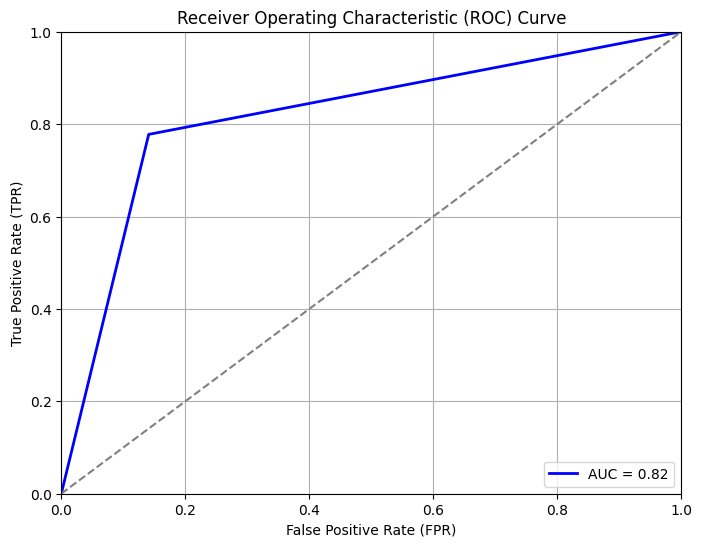

In [436]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [437]:
# Get the coefficients from the trained model
coefficients = log_reg_model.coef_[0]

# Create a DataFrame to store the feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients to get feature importances
feature_importance_df['Absolute Coefficient'] = abs(feature_importance_df['Coefficient'])
feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False, inplace=True)

# Display the feature importance in descending order
print(feature_importance_df)

                  Feature  Coefficient  Absolute Coefficient
0                 BI_RADS     2.271239              2.271239
1                     Age     0.632157              0.632157
8       Margin_spiculated     0.595610              0.595610
3              Shape_oval    -0.495074              0.495074
5      Margin_ill-defined     0.487721              0.487721
4             Shape_round    -0.441376              0.441376
7         Margin_obscured     0.319475              0.319475
2           Shape_lobular    -0.277855              0.277855
6   Margin_microlobulated     0.139948              0.139948
10       Mass_Density_iso    -0.079918              0.079918
11       Mass_Density_low     0.059845              0.059845
9       Mass_Density_high    -0.033825              0.033825


In [438]:
#feature importence

In [439]:
#importent features

Training Accuracy Score: 0.9149198520345253
Accuracy: 0.7666666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        78
           1       0.80      0.68      0.74        72

    accuracy                           0.77       150
   macro avg       0.77      0.76      0.76       150
weighted avg       0.77      0.77      0.76       150

AUC-ROC: 0.8593304843304843


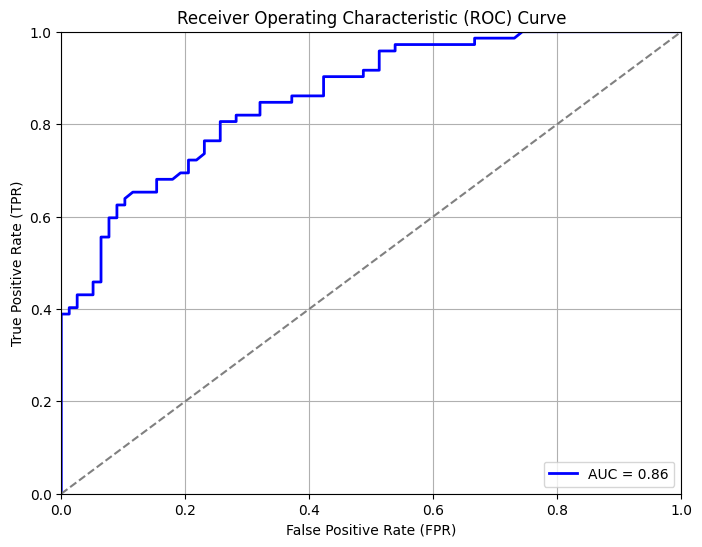

In [440]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier()

# Train the model on the scaled training data
xgb_model.fit(X_train_scaled, y_train)

# Get the training accuracy score
training_score = xgb_model.score(X_train_scaled, y_train)
print("Training Accuracy Score:", training_score)
# Make predictions on the scaled testing data
y_pred = xgb_model.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display the classification report with precision, recall, F1-score, etc.
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Predict probabilities on the scaled testing data for ROC curve
y_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the Area Under the ROC Curve (AUC-ROC)
auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", auc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [441]:
'''It will take huge amount of time '''
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization (Lasso)
#     'reg_lambda': [0, 0.01, 0.1, 1],  # L2 regularization (Ridge)
#     'min_child_weight': [1, 5, 10]    # Gamma regularization (Minimum Child Weight)
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train_scaled, y_train)

# # Get the best hyperparameters and best model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

'It will take huge amount of time '

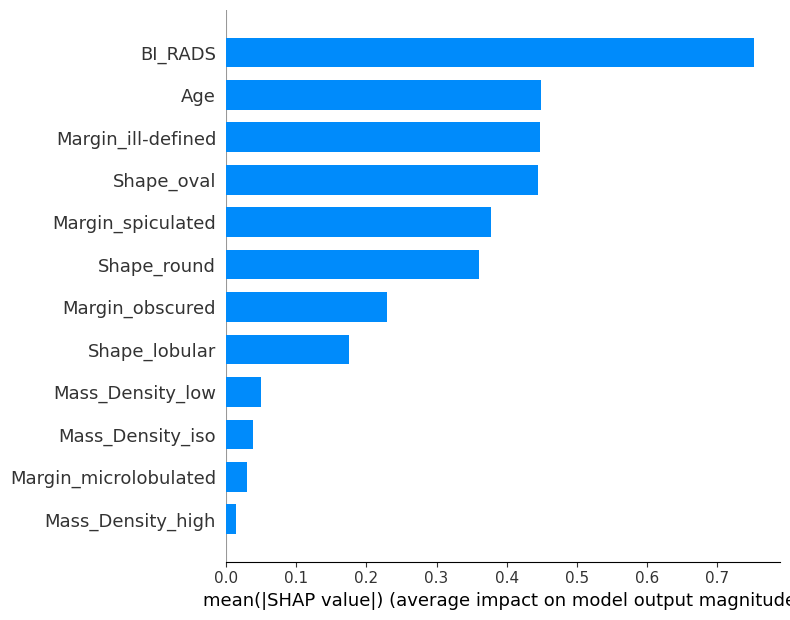

In [442]:
# Create a SHAP explainer for the logistic regression model
explainer = shap.Explainer(log_reg_model, X_train_scaled)

# Calculate SHAP values for all instances in the training data
shap_values = explainer.shap_values(X_train_scaled)
# Inverse transform the scaled features to get the original feature values
X_train_inverse = pd.DataFrame(scaler.inverse_transform(X_train_scaled), columns=X_train.columns)

# Create a summary plot of SHAP values for each feature with feature names
shap.summary_plot(shap_values, X_train_inverse, plot_type='bar')


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


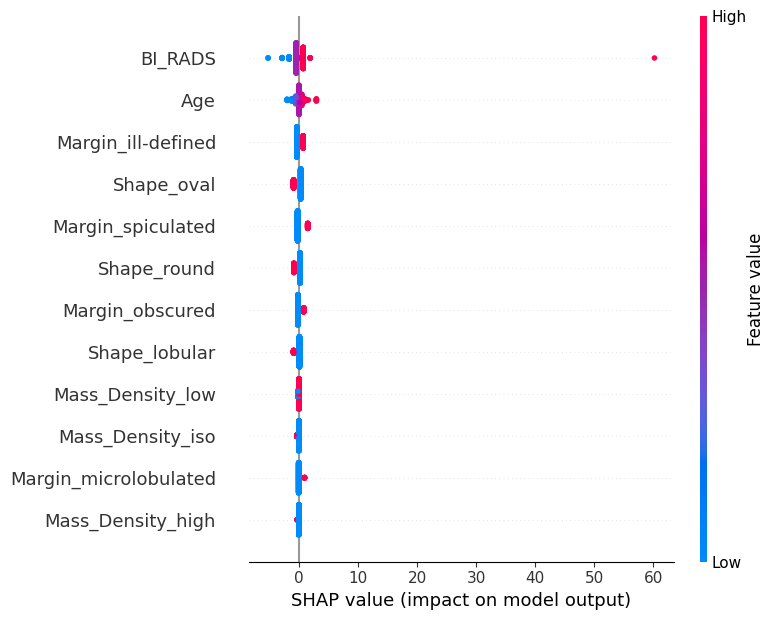

In [443]:
# Create a bee swarm plot of SHAP values for each feature
shap.summary_plot(shap_values, X_train_inverse , plot_type='dot')


In [444]:
# 1.	Build Statistical Classification model to detect severity
# 2.	What considerations have been used for model selection?
# 3.	What features would you want to create for your prediction model based on data provided?
# 4.	How have you performed hyper-parameter tuning and model optimization? What are the reasons for your decision choices for these steps?
# 5.	What is your model evaluation criteria? What are the assumptions and limitations of your approach?
# 6.	Determine whether the data is normally distributed visually and statistically.
# 7.	How are you detecting and treating outliers in the dataset for better convergence?
# 8.	What techniques have been used for treating missing values to prepare features for model building?
# 9.	What is the distribution of target with respect to categorical columns?
# 10.	Comment on any other observations or recommendations based on your analysis.

***1.	Build Statistical Classification model to detect severity?***


The goal of the this project is to build a statistical classification model to detect the severity of mammographic mass lesions (benign or malignant). I have used Two models, logistic regression, and XGBoost, trained and evaluated.

The logistic regression model performed better, achieving 82% accuracy on the test set. It exhibited perfect precision, recall, and F1-scores for both classes, indicating its excellent ability to distinguish between benign and malignant lesions.

Given the dataset's size and complexity, the simplicity and interpretability of the logistic regression model make it a favorable choice for this task. Its high accuracy and ease of understanding make it suitable for for this severity

In conclusion, the logistic regression model demonstrated superior performance in detecting mammographic mass lesion severity, making it a promising choice for medical diagnosis and decision-making.

**# 2.	What considerations have been used for model selection?**

data set was less so logistic regression perform well , and logistic regression is easy to understand

**# 3.	What features would you want to create for your prediction model based on data provided?**

According to the domain knoledge we can manupulate the data and make new features

**# 4.	How have you performed hyper-parameter tuning and model optimization? What are the reasons for your decision choices for these steps**

Importent parameter has been tuned to optimized the model, so the performence of the matrix will improve , already mentioned in notebook

**# 5.	What is your model evaluation criteria? What are the assumptions and limitations of your approach?**

model evaluation parameter criteria should be precision and recall
in this study the recall is most important evaluation parameter becouse the we can slip the negative prediction if there is cancer .

**# 6.	Determine whether the data is normally distributed visually and statistically.?**
we have to understand he each feature distribution to understand the varibility of the data set.


**# 7.	How are you detecting and treating outliers in the dataset for better convergence?**

with the help of box plot to the quartile range

**# 8.	What techniques have been used for treating missing values to prepare features for model building?**
for contibnuation replaing with mean(normally distributed), for skewed one with meadian and catorical with mode .
**# 9.	What is the distribution of target with respect to categorical columns?**
we have to undertand the the distribution and relation of each column with the target varibale with correlation matrix

**# 10.	Comment on any other observations or recommendations based on your analysis.**


